In [161]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 3.1 MNIST

- MNIST dataset는 keras에서 쉽게 다운 받을 수 있는 데이터는 일반적으로 사전형 구조를 가지고 있다.
- data와 데이터의 정보를 담은 label이 자료로 저장이 되어 있으니 나중에 keras dataset을 이용할 일이 생기면 참고하면 될 것이다.

In [162]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)

In [163]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [164]:
mnist['data']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [165]:
mnist['target']

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [166]:
x,y = mnist['data'], mnist['target']
x.shape, y.shape

((70000, 784), (70000,))

- 위에서의 데이터의 shape를 보게 되면 x는 총 7000개의 데이터를 28*28의 픽셀의 이미지화된 데이터를 담고있다는 의미에서 데이터의 특징의 개수가 784개가 나온다.

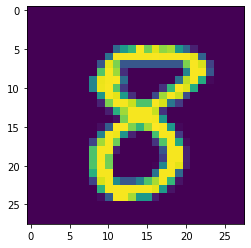

In [167]:
random_img = x[333]
random_img = random_img.reshape(28,28)
plt.imshow(random_img)
plt.show()

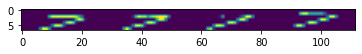

In [168]:
plt.imshow(x[567].reshape(7,112))

- 이미지 데이터를 reshaping하지 않고서는 ```plt.imshow``` 가 불가능하다. 
- 2차원 이미지 데이터만 출력이 가능하다는 해당 출력 함수의 특성 때문이다.

In [169]:
y[567]

'7'

In [170]:
#위에서 알 수 있는 사실을 label속의 데이터가 문자열이기 때문에 이를 정수로 변환시켜야 한다는 것이다.
#머신 러닝 알고리즘은 숫자로 변환된 데이터를 선호한다.
y = y.astype(np.int32)

In [171]:
trainsplit = 6000
x_train, y_train, x_test, y_test = x[:trainsplit], y[:trainsplit], x[trainsplit:], y[trainsplit:]
#이 데이터셋의 경우에는 이미 shuffle이 되어있기는 하지만 나중에 다른 데이터를 다룰 때에는 shuffle을 직접 수행하여서 데이터의 편향을 막아야 한다.

### 3.2 이진 분류기 훈련

- 우선은 숫자들중 하나인 2를 학습시켜보는, class의 개수가 2개인 분류기를 학습시키자.
- 분류 모델을 아무거나 선택해서 우선 하나의 숫자만이라도 학습 시켜보도록 한다.
- 이 경우에는 SGD classifier(확률적 경사 하강법)을 사용하고자 한다.
- 이 분류기는 한번에 하나씩 훈련 샘플을 독립적으로 처리하기 떄문에 대규모 데이터셋을 효율적으로 처리한다.

In [172]:
y_train_2 = (y_train == 2)
y_test_2 = (y_test == 2)

#sklearn의 SGDClassifier, SGDRegressor은 모두 epoch를 반복할 떄마다 데이터를 섞는다.
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(x_train, y_train_2)
sgd_clf.score(x_test, y_test_2)

0.951640625

In [173]:
y_test[2]

1

In [174]:
x_train[325].shape

(784,)

In [175]:
predict = sgd_clf.predict(x_train)
predict[325]

True

### 3.3 성능 측정

#### 3.3.1 교차 검증을 사용한 정확도 측정

In [176]:
#우선 sklearn에 있는 crosss_val_score을 직접 코드를 짜보기로 한다.
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42)
#n_splits의 개수의 데이터 만큼 섞어서 데이터를 만들어 준다.

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [177]:
for train_index, test_index in skfolds.split(x_train, y_train_2):
  clone_clf = clone(sgd_clf)
  x_train_folds = x_train[train_index]
  y_train_folds = y_train_2[train_index]
  x_test_folds = x_test[test_index]
  y_test_folds = y_test_2[train_index]

  clone_clf.fit(x_train_folds, y_train_folds)
  y_pred = clone_clf.predict(x_test_folds)
  correct = 0
  for i in range(len(y_pred)):
    if y_pred[i] == y_test_folds[i]:
      correct += 1
  print(correct/2000)

0.814
0.807
0.8075


In [178]:
#from sklearn.model_selection import cross_val_score을 이용하면
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train_2, cv=3, scoring = 'accuracy')

array([0.959 , 0.963 , 0.9575])

- 그러나 정확도는 분류기의 성능 측정 지표로 선호하지는 않는다.
- 특히나 불균형한 데이터셋을 다룰 때에 그 특성이 두드러지게 드러난다.

#### 3.3.2 오차 행렬
- 오차 행렬을 관찰한다는 것은 클래스 A의 샘플이 클래스 B의 샘플로 잘못 분류된 횟수를 측정하는 것이다. 예를 들면 숫자 2가 숫자 3으로 잘못 분류된 횟수를 알고 싶다면 오차 행렬의 2행 3열을 측정하면 된다.
- 뿐만 아니라 오차 행렬을 만들기 위해서는 실제 타겟과 비교할 수 있도록 예측값을 만들어야 하는데, 이를 위해 cross_val_predict를 이용한다.

In [179]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_2, cv=3)
#이는 cross_val_score과 마찬가지로 k-겹 교차 검증을 수행하기는 하지만 평가 점수를 반환하는 것이 아니라 각 테스트 폴드에서 얻은 예측을 반환하게 된다.

from sklearn.metrics import confusion_matrix
#오차 행렬 만들기
confusion_matrix(y_train_2, y_train_pred)

array([[5285,  134],
       [ 107,  474]])

- matrix[0][0]: 2-2 (TN)
- matrix[0][1]: 2-2아님 (FP)
- matrix[1][0]: 2아님-2 (FN)
- matrix[1][1]: 2아님-2아님 (TP)

1. 정밀도 = TP / (TP + FP)
2. 재현률(분류기가 정확하게 분류한 양성 샘플의 비율) = TP / (TP + FN)
  - 재현율을 측정 지표로서 더 많이 사용한다.

#### 3.3.3 정밀도와 재현율

In [180]:
#굳이 우리가 직접 계산해주지 않아도 sklearn에는 분류기의 지표를 계산하는 여러 함수가 존재한다.
#상황에 따라서 재현율과 정밀도의 중요도의 비중이 다를 수가 있다.
from sklearn.metrics import precision_score, recall_score, f1_score
#정밀도, 재현율, 조화 평균
#조화 평균 = 2/(1/정밀도 + 1/재현율)

- 정밀도와 재현율은 반비례의 관계이고, 따라서 이를 정밀도/재현율 트레이드오프라고 한다.
- 이를 이해해야 SGD Classifier의 작동 원리가 어느 정도 이해가 갈 수 있을 것이다.

#### 3.3.4 정밀도/재현율 트레이드오프
- SGD Classifier은 설정한 임계값 위의 값을 양성으로 판단을 한다.
- 임계값이 높을수록 일반적으로 재현율이 낮아지고 정밀도가 높아진다.
- 따라서 이 임계값을 변형하는 것에 신경을 써야 하는데, 이를 위해 훈련 세트에 있는 모든 함수의 점수를 구해주어야 한다.

In [181]:
y_score = cross_val_predict(sgd_clf, x_train, y_train_2, cv = 3, method = 'decision_function')
#cross_val_predict를 이용해서 값들을 계산해 줄 때에 뒤에 method부분을 바꾸면 되는데 만약 method를 'accuracy'라고 설정해 두면 예측 정확도를 출력하고, 'decision_function'으로 설정해 놓으면 예측 결과가 저장이 된다.
from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve(y_train_2, y_score)
#정밀도, 재현율

In [182]:
precision

array([0.10970544, 0.1095373 , 0.10955799, ..., 1.        , 1.        ,
       1.        ])

In [183]:
recall

array([1.        , 0.99827883, 0.99827883, ..., 0.00344234, 0.00172117,
       0.        ])

In [184]:
threshold

array([-949240.59259303, -948780.1932421 , -948733.15576241, ...,
        918916.60116967,  960725.13218651,  986830.49128991])

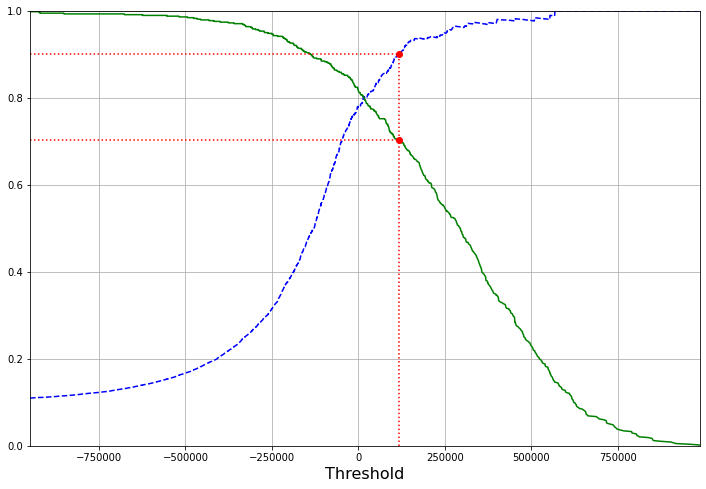

In [185]:
plt.figure(figsize = (12,8)) 
plt.plot(threshold, precision[:-1], 'b--', label = '정밀도')
plt.plot(threshold, recall[:-1], 'g-', label = '재현율')
plt.xlabel("Threshold", fontsize=16)    
plt.axis([min(threshold), max(threshold),0,1]) 
plt.grid()
#정밀도가 0.9보다 큰 지점
recall_90_precision = recall[np.argmax(precision >= 0.90)]
#재현율이 0.9보다 큰 지점
threshold_90_precision = threshold[np.argmax(precision >= 0.90)]
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                
plt.plot([min(threshold), threshold_90_precision], [0.9, 0.9], "r:") 
plt.plot([min(threshold), threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                          
plt.plot([threshold_90_precision], [recall_90_precision], "ro")  
plt.show()

#### 3.3.5 ROC 곡선
- ROC곡선은 수신기 조작 특성 곡선으로, 이진 분류에서 널리 사용되는 도구이다.
- 음성인데 양성으로 잘못 분류된 음성 샘플의 비율을 FPR이라고 한다.
- ROC곡선의 아래 면적인 AUC를 측정하게 되면 분류기의 비교가 가능하다.
  - 완벽한 분류기는 1이고, 완전한 랜덤 분류기는 0.5이다.
  - ```sklearn.metrics import roc_auc_score```을 이용하게 되면 곡선 아래 면적을 구할 수 있게 된다.
- Random Forest Classifier과 SGD Classifier의 성능을 비교해 보고자 한다.

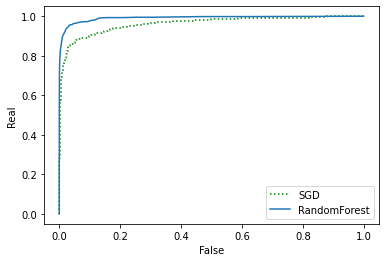

In [186]:
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_train_2, y_score)

from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_2, cv = 3, method = 'predict_proba')
y_score_forest = y_probas_forest[:,1]  #양성 클래스에 대한 확률을 점수로 이용한다.
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_2, y_score_forest)
plt.plot(fpr, tpr, 'g:', label = 'SGD')
plt.plot(fpr_forest, tpr_forest, label = 'RandomForest')
plt.legend(loc = 'lower right')
plt.xlabel('False')
plt.ylabel('Real')
plt.show()


- 전반적으로 Random Forest의 성능이 SGD보다 좋다.
- Random Forest Classifier는 훈련 데이터의 클래스의 비율에 따라 무작위로 예측을 한다.
  - 트리의 노드를 분할할 때에 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 한번 더 주입한다. 이는 결국 트리를 더욱 다양하게 만들고 따라서 편향을 손해보는 대신에 분산을 낮추어 전체적으로 훌륭한 모델을 만들어낸다.

### 3.4  다중 분류
- 원래 logistic regression, Support Vector Machine 같은 알고리즘은 이진 분류만 가능한 반면, SGD Clasification, Random Forest Classification, Naive Bayes 같은 알고리즘은 여러개의 클래스를 직접 처리할 수 있다.
- 그러나 이진 분류만 가능한 알고리즘의 경우에도 여러개를 사용해서 다중 클래스의 분류가 충분히 가능해진다.
  - 예를 들면 특정 숫자 하나만 분류하는 이진 분류기를 10개를 훈련시켜 클래스가 10개인 다중 분류기처럼 이용을 하는데, 모두 학습 시켜서 결정 점수가 제일 높은 것을 클래스로 선택하면 괴는 것이다. 이를 OvR(One-verses-the-rest), 혹은 OvA(One-verses-All)이라고 한다.
  - 또는 0과 1 구별, 0과 2 구별, 1과 2 구별 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련 시켜도 된다. 이는 OvO(One-verses-One)이라고 한다. 이는 클래스가 n개라면 분류기는 nC2개가 필요하다.

In [190]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(x_train, y_train)
svm_clf.predict([x_train[232]])

array([0], dtype=int32)

In [191]:
y_train[232]

0

In [192]:
svm_clf.decision_function([x_train[232]])

array([[ 9.29841293, -0.30232039,  5.22279913,  0.74050388,  4.83382941,
         7.26797946,  8.28179231,  1.73220383,  5.09911763,  2.77053243]])

- 위의 결과를 보면 알 수 있겠지만 정답 index인 0번째 확률값이 제일크다.
- 일반적으로 SVC는 OvA전략을 사용하는데, 다른 전략을 사용하도록 강제가 가능하다.

In [193]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(x_train, y_train)
ovr_clf.predict([x_train[232]])
ovr_clf.decision_function([x_train[232]])

array([[ 0.4028422 , -2.50512446, -1.0188573 , -2.58668457, -1.35123878,
        -1.1233082 , -0.62978172, -1.45844805, -1.5987542 , -2.02980883]])

In [195]:
score1 = cross_val_score(ovr_clf, x_train, y_train, cv = 3, scoring = 'accuracy')
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
new_x = scaler.fit_transform(x_train.astype(np.float64))
score2 = cross_val_score(ovr_clf, new_x, y_train, cv = 3, scoring = 'accuracy')

In [196]:
print(score1, score2)

[0.9385 0.952  0.948 ] [0.9085 0.9355 0.916 ]


- standard scaler을 이용해서 데이터의 스케일에 변형을 주었더니 그것 만으로도 정확도 점수가 올라가는 것을 확인할 수 있을 줄 알았다. '제대로 된' 데이터 전처리의 중요성을 깨닳을 수 있었던 것이라고 생각한다.

### 3.5 에러 분석
- 실제 실무에서 다루는 프로젝트를 진행중이라면 다양한 분류기와 학습기를 만들어 놓고 다양한 모델들을 GridSearchCV와 같은 것을 이용해서 하이퍼파라미터를 튜닝할 것이다.
- 이번에는 하나의 최적의 모델을 찾았다고 가정하고 이 모델의 성능을 향상시킬 방법을 찾아보자

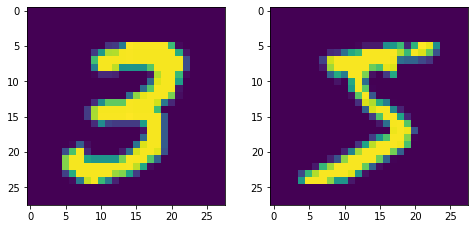

In [229]:
cl_a, cl_b = 3,5
x_aa = x_train[(y_train == cl_a) & (y_train == cl_a)]
x_ab = x_train[(y_train == cl_a) & (y_train == cl_b)]
x_ba = x_train[(y_train == cl_b) & (y_train == cl_a)]
x_bb = x_train[(y_train == cl_b) & (y_train == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plt.imshow(x_aa[0].reshape(28,28))
plt.subplot(222); plt.imshow(x_bb[i].reshape(28,28))

- 분류기는, 특히 이미지를 다룰 때에 이미지의 위치나 회전 방향에 매우 민감하다. 따라서 3과 5 사이에 오류가 발생했다면 이를 줄이기 위해서 이미지를 중앙에 위치시키고 회전되지 않도록 전처리 하는 것도 좋은 방법이다.

### 3.6 다중 레이블 분류
- 예를 들면 얼굴 인식 분류기는 하나의 사진에서 a있음,b없음,c있음 이런 식으로 하나의 입력값에 대한 다수의 label을 예측해야 할 것이다.
- 이렇게 여러개의 이진 꼬리표를 출력하는 것을 '다중 레이블 분류'라고 한다.

In [241]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train%2 == 1)
y_multilabel = []
for i in range(len(y_train_large)):
  temp = []
  temp.append(y_train_large[i])
  temp.append(y_train_odd[i])
  y_multilabel.append(temp)
y_multilabel = np.array(y_multilabel)

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [242]:
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [ True, False],
       [False, False],
       [ True,  True]])

In [247]:
knn_clf.predict([x_train[77]])

array([[False,  True]])

In [248]:
y_multilabel[77]

array([False,  True])

In [249]:
y_train[77]

1

- 숫자는 1이었고, 7보다 크지 않으며(False) 홀수(True)로 올바르게 분류를 했다.
- 나중에 레이블에 클래스의 지지도, 즉 타깃 레이블에 속한 샘플의 수를 가중치로 두어서 계산을 한다면 편차를 훨씬 줄일 수 있을 것이다.

### 3.7 다중 출력 분류
- Multioutput-Multiclass-Classification이란 다중 레이블 분류에서 하나의 레이블이 다중 클래스가 될 수 있도록 일반화 한 것이다.
- 이를 위해서 이미지에서 잡음을 제거하는 시스템을 만들어 보고자 한다.
- 잡음이 많은 숫자의 이미지를 입력으로 받아서 잡음이 제거된 이미지의 배열을 픽셀의 가중치가 반영된 형태로 출력하는 것이 목표이다.
  - 각각의 이미지가 28*28개의 레이블을 가지며 각 레이블이 (0-255)까지의 픽셀 강도를 갖기 때문에 다중 출력 분류가 맞다.
  - 실제 MNIST이미지는 잡음이 제거된 깨끗한 형태이므로 먼저 잡음을 추가하고 원본 이미지와 맞는 이미지가 출력이 되는지 확인해 볼 것이다.

In [251]:
noise = np.random.randint(0,100,(len(x_train), 784))
x_train_noise = x_train+noise
noise = np.random.randint(0,100,(len(x_test), 784))
x_test_noise = x_test+noise
y_train_noise = x_train
y_test_noise = x_test

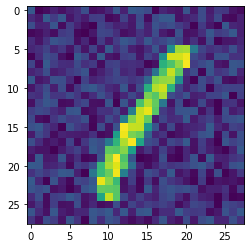

In [252]:
plt.imshow(x_train_noise[3].reshape(28,28))

In [253]:
knn_clf.fit(x_train_noise, y_train_noise)
clean_pred = knn_clf.predict([x_test_noise[34]])

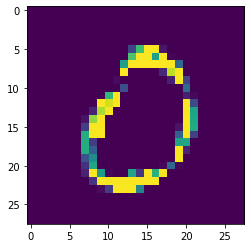

In [254]:
plt.imshow(clean_pred.reshape(28,28))

- 이로써 주변의 잡음이 사라진 것을 알 수 있다.